# Realistic Charge Sensor
In this notebook, I will develop a model for the output of a realistic charge sensor. Two parallel nanowires will be simulated each with its own set of gates. The goal is to produce transport characterisitics of the two nanowires and get a working charge sensor output.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [12]:
def calc_gate_potential(x,y,gate_param):
    '''
    Calculates the potential at each point in x
    '''
    peak = gate_param['peak']
    pos_x = gate_param['pos_x']
    pos_y = gate_param['pos_y']
    rho = gate_param['rho']
    h = gate_param['h']
    screen = gate_param['screen']
    
    dx = np.sqrt((x-pos_x)**2 + (y[:,np.newaxis]-pos_y)**2)
    return -1.0*(peak/np.log(h/rho))*np.log(np.sqrt(dx**2 + h**2)/rho)*np.exp(-dx/screen)

def calc_potential(x,y,gate_dict):
    '''
    Calculates the potentials as sum from all gates in gate_dict
    '''
    for key,item in gate_dict.items():
        return np.sum([calc_gate_potential(x,y,gate) for key,gate in gate_dict.items()],axis=0)

## Gate Parameters
Define the voltages set to the gates and their positions here.

In [53]:
# all distances in nm
# depth of 2DEG 
h = 50
# radius of gates
rho = 5
# distance between dot nanowire and sensor nanowire
d = -50
# screening length
screen = 20

gate1_dot = {
    'peak'   : -100e-3,
    'pos_x'  : -20,
    'pos_y'  : 0,
    'rho'    : rho,
    'h'      : h,
    'screen' : screen,
}

gate2_dot = {
    'peak'   : 100e-3,
    'pos_x'  : 0,
    'pos_y'  : 0,
    'rho'    : rho,
    'h'      : h,
    'screen' : screen,
}
gate3_dot = {
    'peak'   : -100e-3,
    'pos_x'  : 20,
    'pos_y'  : 0,
    'rho'    : rho,
    'h'      : h,
    'screen' : screen,
}

gate1_sensor = {
    'peak'   : -50e-3,
    'pos_x'  : -15,
    'pos_y'  : d,
    'rho'    : rho,
    'h'      : h,
    'screen' : screen,
}

gate2_sensor = {
    'peak'   : -50e-3,
    'pos_x'  : 15,
    'pos_y'  : d,
    'rho'    : rho,
    'h'      : h,
    'screen' : screen,
}

gate_dict = {
    'gate1_dot' : gate1_dot,
    'gate2_dot' : gate2_dot,
    'gate3_dot' : gate3_dot,
    'gate1_sensor' : gate1_sensor,
    'gate2_sensor' : gate2_sensor,
}

# Potential Profile Calculation
Once the gates are defined, I will calculate the potential profile as a function of x at two y-values (y = 0 and y = d) corresponding the dot and sensor nanowire. 

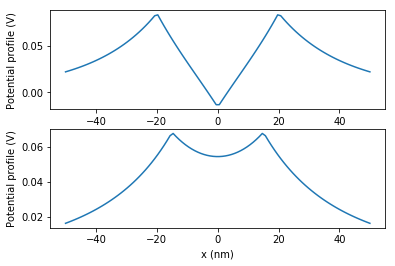

In [54]:
x = np.linspace(-50,50,100)

V1 = calc_potential(x,np.array([0]),gate_dict).flatten()
V2 = calc_potential(x,np.array([d]),gate_dict).flatten()

fig,axarr = plt.subplots(2,1)
axarr[0].plot(x,V1)
axarr[0].set_xlabel('x (nm)')
axarr[0].set_ylabel('Potential profile (V)')

axarr[1].plot(x,V2)
axarr[1].set_xlabel('x (nm)')
axarr[1].set_ylabel('Potential profile (V)')

# 2D map of potential
In order to just see how the potential looks in the 2DEG, I will calculate it in the full plane.

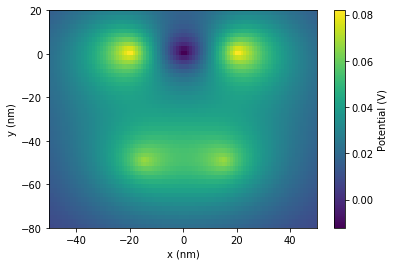

In [57]:
x = np.linspace(-50,50,100)
y = np.linspace(-80,20)
V_map = calc_potential(x,y,gate_dict)

XX,YY = np.meshgrid(x,y)
plt.pcolor(XX,YY,V_map)
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
cbar = plt.colorbar()
cbar.set_label('Potential (V)')

## Calculation of the electron density
Next step is to calculate the electron density in the 2DEG plane. This is too complicated and numerically expensive. Instead, I can just restrict the calculation to two nanowires located at two y-values.

In [71]:
def calc_K_dot_mat(params):
    '''
    Calculates the Coulomb interaction matrix on the dot nanowire
    '''
    x_dot = params['x_dot']
    K_0 = params['K_0']
    sigma = params['sigma']
    
    dx = np.sqrt((x_dot - x_dot[:,np.newaxis])**2 + sigma**2)
    # sigma in the numerator is added for normalisation, so that value at x = 0 is same irrespective of change
    # in sigma
    K_mat = K_0*sigma/dx 
    return K_mat 

def calc_K_sensor_mat(params):
    '''
    Calculates the Coulomb interaction matrix on the dot nanowire
    '''
    x_sensor = params['x_sensor']
    K_0 = params['K_0']
    sigma = params['sigma']
    
    dx = np.sqrt((x_sensor - x_sensor[:,np.newaxis])**2 + sigma**2)
    # sigma in the numerator is added for normalisation, so that value at x = 0 is same irrespective of change
    # in sigma
    K_mat = K_0*sigma/dx 
    return K_mat 
    
def calc_K_dot_sensor_mat(params):
    '''
    Calculates the Coulomb interaction matrix between the dot nanowire and sensor nanowire
    '''
    x_dot = params['x_dot']
    K_0 = params['K_0']
    sigma = params['sigma']
    d = params['d']
    
    dx = np.sqrt((x_dot - x_sensor[:,np.newaxis])**2 + d**2 + sigma**2)
    # sigma in the numerator is added for normalisation, so that value at x = 0 is same irrespective of change
    # in sigma
    K_mat = K_0*sigma/dx 
    return K_mat 
    
def calc_n(params):
    '''
    Calculate the self-consistent electron density for x linspace
    '''
    mu = params['mu']
    g_0 = params['g_0']
    beta = params['beta']
    V_dot = params['V_dot']
    V_sensor = params['V_sensor']
    K_dot_mat = params['K_dot_mat']
    K_sensor_mat = params['K_sensor_mat']
    K_dot_sensor_mat = params['K_dot_sensor_mat']
    
    def polylog_f(x):
        '''
        Density for 2DEG
        '''
        output = (g_0/beta) * np.log(1 + np.exp(beta * x))
        return output

    n_dot = np.zeros(len(V_dot))
    n_dot_prev = np.zeros(len(V_dot))
    phi_dot = np.zeros(len(V_dot))

    n_sensor = np.zeros(len(V_sensor))
    n_sensor_prev = np.zeros(len(V_sensor))
    phi_sensor = np.zeros(len(V_sensor))
    
    for i in range(100):
        # turn on the Coulomb over 10 steps
        if i < 10:
            phi_dot = (i/10) * (np.dot(K_dot_mat,n_dot) + np.dot(K_dot_sensor_mat,n_sensor))
            # transpose taken of K_dot_sensor_mat to ensure right x indices of K(x,x') go in
            # irrelevant if the x linspaces of dot and sensor are the same
            phi_sensor = (i/10) * (np.dot(K_sensor_mat,n_sensor) + np.dot(K_dot_sensor_mat.T,n_dot))
            
        n_dot_prev = n_dot
        n_dot = polylog_f(mu - V_dot + phi_dot)
        n_sensor = polylog_f(mu - V_sensor + phi_sensor)

        if (i > 10) and (np.linalg.norm(n_dot - n_dot_prev)**2 < \
                         (1e-12) * np.linalg.norm(n_dot) * np.linalg.norm(n_dot_prev))\
                    and (np.linalg.norm(n_sensor - n_sensor_prev)**2 < \
                         (1e-12) * np.linalg.norm(n_sensor) * np.linalg.norm(n_sensor_prev)):             
            print("Done in",i)
            break;
    n_dot = np.real(n_dot)
    n_sensor = np.real(n_sensor)
    # filter the very low electron density points
    n_dot[n_dot < 1e-10] = 0
    n_sensor[n_sensor < 1e-10] = 0
    return n_dot,n_sensor

In [75]:
x_dot = np.linspace(-50,50,100)
x_sensor = np.linspace(-50,50,100)

# note that the gate parameters are defined above
V_dot = calc_potential(x,np.array([0]),gate_dict).flatten()
V_sensor = calc_potential(x,np.array([d]),gate_dict).flatten()

params = {
    'x_dot'    : x_dot,
    'x_sensor' : x_sensor,
    'd'        : d,
    'V_dot'    : V_dot,
    'V_sensor' : V_sensor,
    'K_0'      : 1e-2,
    'sigma'    : 2,
    'g_0'      : 1,
    'beta'     : 1000,
    'mu'       : 0.4,
}
params['K_dot_mat'] = calc_K_dot_mat(params)
params['K_sensor_mat'] = calc_K_sensor_mat(params)
params['K_dot_sensor_mat'] = calc_K_dot_sensor_mat(params)

In [76]:
n_dot,n_sensor = calc_n(params)

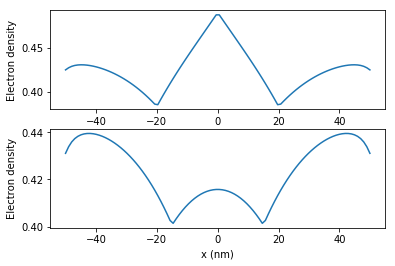

In [80]:
fig,axarr = plt.subplots(2,1)

axarr[0].plot(x_dot,n_dot)
axarr[0].set_xlabel('x (nm)')
axarr[0].set_ylabel('Electron density')

axarr[1].plot(x_sensor,n_sensor)
axarr[1].set_xlabel('x (nm)')
axarr[1].set_ylabel('Electron density')

# Calculation of Charges
I will calculate the charge from the electron desnity summnation on the dot and sensor nanowires. I will make a plot of the charge on dot and sensor from changing the dot voltage to see if the sensor works.

In [86]:
def calc_islands_and_barriers(n):
        # n_eps sets the scale below which an island is assumed to end
        # adaptive eps makes the calculation more robust 
        n_eps = 1e-1*np.max(n)
        
        n_chop = np.concatenate(([0],np.array([1 if x > n_eps else 0.0 for x in n]),[0]))
        # replace non-zero elements by 1
        n_diff = np.abs(np.diff(n_chop))
        islands = np.where(n_diff == 1)[0].reshape(-1, 2)
        
        n_chop_bar = np.concatenate(([0],np.array([0 if x > n_eps else 1 for x in n]),[0]))
        n_diff = np.abs(np.diff(n_chop_bar))
        barriers = np.where(n_diff == 1)[0].reshape(-1, 2)
        
        # has to be copy since I will be popping off elemets from the islands list
        all_islands = islands.copy()
        # ignore the leads
        # in case the leads are absent, their absence is ignored
       
        islands = list(islands)
        
        # certain edge cases handled here
        if(len(islands) == 0):
            # The system is a complete barrier with no islands, n = 0 
            pass
        elif(len(islands) == 1 and islands[0][0] == 0 and islands[0][1] == (len(n))):
            # short-circuit condition with electron density all over
            islands.pop(0)
        # if left and right leads are present, they are popped off since they do not form quantum dot islands 
        if(islands != [] and islands[0][0] == 0):
            islands.pop(0)
        if(islands != [] and islands[-1][1] == (len(n))):
            islands.pop(-1)
        return islands,barriers

In [87]:
dot_islands,dot_barriers = calc_islands_and_barriers(n_dot)
print(dot_islands,dot_barriers)
sensor_islands,sensor_barriers = calc_islands_and_barriers(n_sensor)
print(sensor_islands,sensor_barriers)

[] []
[] []
